<a href="https://colab.research.google.com/github/dettorig/RenyiKSDforGANs/blob/main/src/notebooks/ksd_gan_cifar10_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rényi-Nyström KSD-GAN Training on CIFAR-10 (Backup)

This is a backup/alternative implementation of the KSD-GAN training notebook.

## Project Overview

This project replaces the classical adversarial discriminator in GAN training with a kernel-based distance metric (KSD). The implementation uses:
- **Nyström-KSD estimator** for computational efficiency (reduces O(n²) to O(m²) complexity)
- **Rényi-based landmark selection** for diverse and informative landmark points
- **Feature-space Stein kernels** via random projections or pretrained ResNet features
- **DDPM score functions** from a pretrained diffusion model

## Code Attribution

**Note:** This code was developed with assistance from ChatGPT for implementation guidance. The Nyström-KSD implementation is based on the work by Kalinke, Szabó, and Sriperumbudur (AISTATS 2025). The core KSD formulation follows standard kernel methods literature, adapted for GAN training.

device: cuda


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


[KSD-GAN] step   25/1000 | loss=23.2087 | t_list=[820]
[KSD-GAN] step   50/1000 | loss=23.0164 | t_list=[751]
[KSD-GAN] step   75/1000 | loss=169.2886 | t_list=[114]
[KSD-GAN] step  100/1000 | loss=27.1996 | t_list=[420]
[KSD-GAN] step  125/1000 | loss=24.1559 | t_list=[866]
[KSD-GAN] step  150/1000 | loss=24.2533 | t_list=[784]
[KSD-GAN] step  175/1000 | loss=24.3069 | t_list=[930]
[KSD-GAN] step  200/1000 | loss=24.8879 | t_list=[541]
[KSD-GAN] step  225/1000 | loss=24.6971 | t_list=[739]
[KSD-GAN] step  250/1000 | loss=24.3537 | t_list=[934]
[KSD-GAN] step  275/1000 | loss=24.0538 | t_list=[629]
[KSD-GAN] step  300/1000 | loss=24.3605 | t_list=[914]
[KSD-GAN] step  325/1000 | loss=263.2967 | t_list=[88]
[KSD-GAN] step  350/1000 | loss=23.8696 | t_list=[762]
[KSD-GAN] step  375/1000 | loss=23.3835 | t_list=[800]
[KSD-GAN] step  400/1000 | loss=23.0397 | t_list=[794]
[KSD-GAN] step  425/1000 | loss=27.1808 | t_list=[445]
[KSD-GAN] step  450/1000 | loss=188.2277 | t_list=[111]
[KSD-GAN

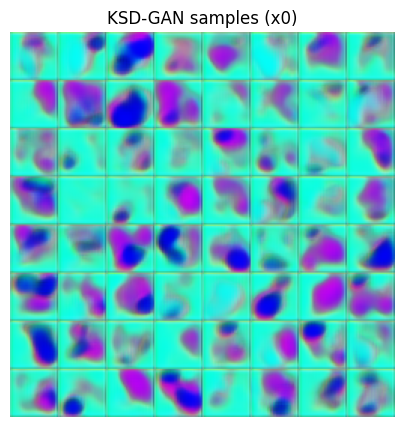

[GAN] step  250/1000 | lossD=1.131 | lossG=1.391
[GAN] step  500/1000 | lossD=1.527 | lossG=0.983
[GAN] step  750/1000 | lossD=1.425 | lossG=1.186
[GAN] step 1000/1000 | lossD=1.302 | lossG=1.108


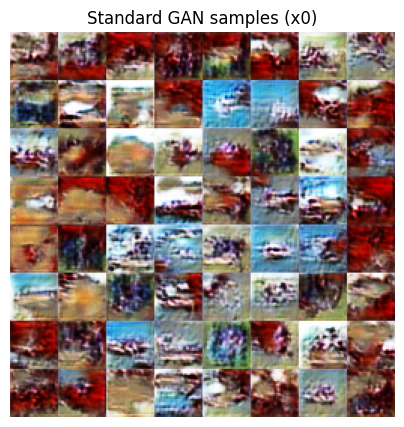

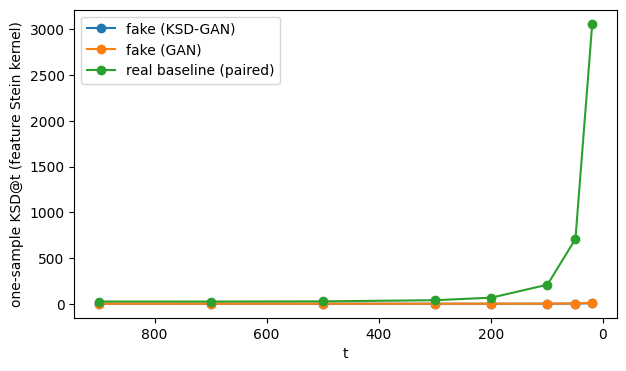

In [6]:
# ============================================================
# "Definitive" Rényi-Nyström KSD-GAN vs Standard GAN (CIFAR-10 32x32)
#
# Key properties:
# - Feature-space Stein kernel via fixed random linear projection z = x P^T
# - Feature normalization (mu/std) computed from REAL ONLY (per t)
# - Bandwidth sigma2 via median heuristic in normalized feature space (REAL ONLY)
# - Landmark selection is STRICTLY NO-GRAD and uses REAL ONLY
# - Two-sample Nyström-KSD: gradients flow only through FAKE
# - Optional small MMD stabilizer in the SAME feature space
# - Multi-t mixture sampler increasingly focusing on low t
# ============================================================

import os, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from diffusers import DDPMPipeline

# ----------------------------
# Repro / device
# ----------------------------
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ============================================================
# (1) Load pretrained DDPM (CIFAR-10)
# ============================================================
# Note: You may see a warning about safetensors missing and "unsafe serialization".
# That is not fatal; diffusers falls back to .bin. If you want to *force* safetensors,
# pass use_safetensors=True and handle errors, but this model snapshot often uses .bin.
pipe = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
pipe.set_progress_bar_config(disable=True)
unet = pipe.unet.eval()
for p in unet.parameters():
    p.requires_grad_(False)

scheduler = pipe.scheduler
alphas_cumprod = scheduler.alphas_cumprod.to(device)
T = alphas_cumprod.numel()

# DDPM marginal: x_t = sqrt(a_bar) x0 + sqrt(1-a_bar) eps
def add_ddpm_noise(x0, t, eps=None):
    if eps is None:
        eps = torch.randn_like(x0)
    a_bar = alphas_cumprod[int(t)]
    mean_coeff = torch.sqrt(a_bar)
    sigma_t = torch.sqrt(1.0 - a_bar)
    x_t = mean_coeff * x0 + sigma_t * eps
    return x_t, sigma_t

def score_fn_xt(x_t, t, sigma_t=None, with_grad=False):
    # score ≈ ∇ log p_t(x_t) ≈ -(eps_pred / sigma_t)
    t = int(t)
    if sigma_t is None:
        sigma_t = torch.sqrt(1.0 - alphas_cumprod[t])
    t_tensor = torch.full((x_t.shape[0],), t, device=x_t.device, dtype=torch.long)
    if with_grad:
        eps_pred = unet(x_t, t_tensor).sample
    else:
        with torch.no_grad():
            eps_pred = unet(x_t, t_tensor).sample
    return -(eps_pred / sigma_t)

# ============================================================
# (2) CIFAR loader in [-1,1]
# ============================================================
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda z: z * 2 - 1),
])
cifar = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
loader = torch.utils.data.DataLoader(
    cifar, batch_size=64, shuffle=True, num_workers=2, drop_last=True
)

# ============================================================
# (3) Feature map: fixed random projection
# ============================================================
class RandomProjection(nn.Module):
    """
    z = X_flat @ P^T where P is (d_proj, D) stored as buffer.
    """
    def __init__(self, D: int, d_proj: int = 512, seed: int = 123, scale: str = "ortho"):
        super().__init__()
        g = torch.Generator()
        g.manual_seed(seed)
        P = torch.randn(d_proj, D, generator=g)
        if scale == "ortho":
            P = P / math.sqrt(d_proj)
        elif scale == "standard":
            P = P / math.sqrt(D)
        self.register_buffer("P", P)

    def forward(self, X_flat: torch.Tensor) -> torch.Tensor:
        return X_flat @ self.P.t()

@torch.no_grad()
def proj_stats_from_real(real_t, feat_map: nn.Module, eps=1e-6):
    B = real_t.size(0)
    Z = feat_map(real_t.view(B, -1))
    mu = Z.mean(dim=0, keepdim=True)
    std = Z.std(dim=0, keepdim=True).clamp_min(eps)
    return mu.detach(), std.detach()

def apply_proj_norm(X_t, feat_map: nn.Module, mu, std):
    B = X_t.size(0)
    Z = feat_map(X_t.view(B, -1))
    return (Z - mu) / std

@torch.no_grad()
def median_sigma2_from_real(real_t, feat_map: nn.Module, mu, std,
                            num_pairs=512, eps=1e-6, clamp_min=1e-3, clamp_max=1e3):
    Z = apply_proj_norm(real_t, feat_map, mu, std)
    B = Z.size(0)
    i = torch.randint(0, B, (num_pairs,), device=real_t.device)
    j = torch.randint(0, B, (num_pairs,), device=real_t.device)
    dist2 = ((Z[i] - Z[j])**2).sum(dim=1)
    med = torch.median(dist2)
    sigma2 = 0.5 * med + eps
    sigma2 = float(torch.clamp(sigma2, clamp_min, clamp_max).item())
    return sigma2

# ============================================================
# (4) MMD^2 in normalized feature space (unbiased)
# ============================================================
def mmd2_rbf_feat_norm(real_t, fake_t, feat_map, mu, std, sigma2: float, eps: float = 1e-12):
    Zr = apply_proj_norm(real_t, feat_map, mu, std)
    Zf = apply_proj_norm(fake_t, feat_map, mu, std)
    n, m = Zr.size(0), Zf.size(0)
    if n < 2 or m < 2:
        raise ValueError("Need at least 2 samples per batch for unbiased MMD^2")

    XX = torch.cdist(Zr, Zr, p=2.0)**2
    YY = torch.cdist(Zf, Zf, p=2.0)**2
    XY = torch.cdist(Zr, Zf, p=2.0)**2

    Kxx = torch.exp(-XX / (2.0 * sigma2))
    Kyy = torch.exp(-YY / (2.0 * sigma2))
    Kxy = torch.exp(-XY / (2.0 * sigma2))

    Kxx_sum = (Kxx.sum() - torch.diagonal(Kxx).sum()) / (n * (n - 1) + eps)
    Kyy_sum = (Kyy.sum() - torch.diagonal(Kyy).sum()) / (m * (m - 1) + eps)
    Kxy_sum = Kxy.mean()

    return torch.clamp(Kxx_sum + Kyy_sum - 2.0 * Kxy_sum, min=0.0)

# ============================================================
# (5) Nyström two-sample KSD in normalized feature space
# ============================================================
class RenyiNystroemKSD(nn.Module):
    def __init__(self, feat_map: nn.Module, ridge=1e-3, m_fn=lambda n: int(4*np.sqrt(n))):
        super().__init__()
        self.feat_map = feat_map
        self.ridge = float(ridge)
        self.m_fn = m_fn

    def h_p(self, X, Y, t, sigma_t, sigma2, mu, std, with_grad_score=False):
        """
        Stein kernel with base k(x,y)=exp(-||z_x - z_y||^2/(2*sigma2))
        where z = (P x - mu)/std  (mu/std fixed from REAL)
        """
        n, m = X.shape[0], Y.shape[0]
        X_flat = X.view(n, -1)
        Y_flat = Y.view(m, -1)

        # scores in x-space
        sX = score_fn_xt(X, t, sigma_t, with_grad=with_grad_score).view(n, -1)
        sY = score_fn_xt(Y, t, sigma_t, with_grad=with_grad_score).view(m, -1)

        # normalized features
        Zx = (self.feat_map(X_flat) - mu) / std
        Zy = (self.feat_map(Y_flat) - mu) / std

        diffz = Zx[:, None, :] - Zy[None, :, :]          # (n,m,d)
        dist2 = (diffz * diffz).sum(dim=2)               # (n,m)
        K = torch.exp(-dist2 / (2.0 * sigma2))           # (n,m)

        # ∇_z k = -(z_x - z_y)/sigma2 * k
        gradZ = -(diffz / sigma2) * K[:, :, None]        # (n,m,d)

        # z = (P x - mu)/std  => dz/dx = diag(1/std) P
        P = self.feat_map.P                               # (d, D)
        invstd = (1.0 / std).view(-1)                     # (d,)
        P_eff = P * invstd[:, None]                       # (d, D)

        # ∇_x k = P_eff^T ∇_z k
        gradX = torch.einsum("nmd, dD -> nmD", gradZ, P_eff)  # (n,m,D)
        gradY = -gradX

        # Terms:
        gram = sX @ sY.T
        B = (gradX * sY[None, :, :]).sum(dim=2)
        C = (gradY * sX[:, None, :]).sum(dim=2)

        # tr(∇_x ∇_y k) = k*(||diffz||^2/sigma2^2 - tr(P_eff P_eff^T)/sigma2)
        trP = torch.sum(P_eff * P_eff)                    # scalar
        gradXY = (trP / sigma2 - dist2 / (sigma2**2)) * K

        return K * gram + B + C + gradXY

    @torch.no_grad()
    def stabilize_Hmm(self, H_mm):
        H_mm = 0.5 * (H_mm + H_mm.T)
        I = torch.eye(H_mm.shape[0], device=H_mm.device, dtype=H_mm.dtype)
        min_eig = torch.linalg.eigvalsh(H_mm).min()
        shift = (-min_eig).clamp(min=0.0)
        return H_mm + (shift + self.ridge) * I

    def two_sample_with_landmarks(self, real_t, fake_t, t, sigma_t, Z_m, sigma2, mu, std, with_grad_fake_score=True):
        """
        delta = beta_fake - beta_real
        stat = delta^T (H_mm_reg^{-1}) delta
        Gradients flow only through fake_t (and fake score).
        """
        real_t = real_t.detach()
        Z_m = Z_m.detach()

        n_r = real_t.size(0)
        n_f = fake_t.size(0)

        H_mm = self.h_p(Z_m, Z_m, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std, with_grad_score=False)
        H_mm_reg = self.stabilize_Hmm(H_mm)

        H_mr = self.h_p(Z_m, real_t, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std, with_grad_score=False)
        H_mf = self.h_p(Z_m, fake_t, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std, with_grad_score=with_grad_fake_score)

        beta_r = H_mr @ (torch.ones(n_r, 1, device=real_t.device, dtype=H_mr.dtype) / n_r)
        beta_f = H_mf @ (torch.ones(n_f, 1, device=fake_t.device, dtype=H_mf.dtype) / n_f)

        delta = beta_f - beta_r
        x = torch.linalg.solve(H_mm_reg, delta)
        return (delta.T @ x).squeeze()

    @torch.no_grad()
    def one_sample_with_landmarks(self, X_t, t, sigma_t, Z_m, sigma2, mu, std):
        n = X_t.size(0)
        H_mn = self.h_p(Z_m, X_t, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std, with_grad_score=False)
        H_mm = self.h_p(Z_m, Z_m, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std, with_grad_score=False)
        H_mm_reg = self.stabilize_Hmm(H_mm)
        beta = H_mn @ (torch.ones(n, 1, device=X_t.device, dtype=H_mn.dtype) / n)
        x = torch.linalg.solve(H_mm_reg, beta)
        return (beta.T @ x).squeeze()

# ============================================================
# (6) Landmark selection (FIXED: pass mu/std!)
# ============================================================
@torch.no_grad()
def select_renyi_landmarks_stein(ksd_obj, X_t, t, sigma_t, sigma2, mu, std, m,
                                use_abs=True, jitter=0.0):
    """
    Must be called under no_grad. X_t must be REAL (detached).
    """
    n = X_t.size(0)
    m = min(int(m), n)

    H = ksd_obj.h_p(X_t, X_t, t=int(t), sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std, with_grad_score=False)
    H = 0.5 * (H + H.T)
    if jitter > 0:
        H = H + jitter * torch.eye(n, device=X_t.device, dtype=H.dtype)

    A = H.abs() if use_abs else H
    diag = torch.diagonal(A)
    row_sums = A.sum(dim=1)
    first = torch.argmin(row_sums).item()

    selected = [first]
    cross_sums = A[:, first].clone()
    while len(selected) < m:
        scores = 2 * cross_sums + diag
        scores[selected] = float("inf")
        nxt = torch.argmin(scores).item()
        selected.append(nxt)
        cross_sums += A[:, nxt]

    return torch.tensor(selected, device=X_t.device, dtype=torch.long)

# ============================================================
# (7) Generator: Upsample+Conv (reduces checkerboard)
# ============================================================
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        return x

class GenX0(nn.Module):
    """
    Generator for x0 in [-1,1] (tanh at the end).
    This is the recommended training mode for your KSD-GAN.
    """
    def __init__(self, z_dim=128, ch=256):
        super().__init__()
        self.fc = nn.Linear(z_dim, ch*4*4)
        self.up1 = UpBlock(ch, ch//2)    # 4->8
        self.up2 = UpBlock(ch//2, ch//4) # 8->16
        self.up3 = UpBlock(ch//4, ch//8) # 16->32
        self.out = nn.Conv2d(ch//8, 3, 3, padding=1)

    def forward(self, z):
        # z: (B,z_dim,1,1) or (B,z_dim)
        if z.dim() == 4:
            z = z[:, :, 0, 0]
        x = self.fc(z).view(z.size(0), -1, 4, 4)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = torch.tanh(self.out(x))
        return x

class GenXt(nn.Module):
    """
    OPTIONAL: Generator for x_t directly.
    IMPORTANT: do NOT tanh by default; x_t is not strictly bounded.
    If you do tanh here, you often get saturation + grids.
    """
    def __init__(self, z_dim=128, ch=256):
        super().__init__()
        self.fc = nn.Linear(z_dim, ch*4*4)
        self.up1 = UpBlock(ch, ch//2)
        self.up2 = UpBlock(ch//2, ch//4)
        self.up3 = UpBlock(ch//4, ch//8)
        self.out = nn.Conv2d(ch//8, 3, 3, padding=1)

    def forward(self, z):
        if z.dim() == 4:
            z = z[:, :, 0, 0]
        x = self.fc(z).view(z.size(0), -1, 4, 4)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.out(x)   # NO tanh
        return x

# ============================================================
# (8) Discriminator for baseline GAN
# ============================================================
class DCGANDis(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)

# ============================================================
# (9) Visualization helpers
# ============================================================
@torch.no_grad()
def show_samples(x, title="samples", n=64):
    x = x[:n].detach().cpu()
    # map to [0,1] for display only
    x = (x + 1) / 2.0
    s = int(np.sqrt(n))
    x = x[:s*s]
    grid = x.view(s, s, 3, 32, 32).permute(0, 3, 1, 4, 2).reshape(s*32, s*32, 3).numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

def sample_t_mixture(step, steps_total, T,
                     t_hi=(0.70, 0.95),
                     t_mid=(0.20, 0.70),
                     t_lo=(0.02, 0.15),
                     p_lo_final=0.60,
                     p_hi_initial=0.60,
                     K_T=4):
    frac = step / max(1, steps_total - 1)
    p_lo = (p_lo_final) * frac
    p_hi = (p_hi_initial) * (1 - frac)
    p_mid = max(0.0, 1.0 - p_lo - p_hi)

    def draw_from(rng):
        a = int(rng[0] * (T-1))
        b = int(rng[1] * (T-1))
        return int(torch.randint(a, b+1, (1,), device=device).item())

    ts = []
    for _ in range(K_T):
        u = np.random.rand()
        if u < p_lo:
            ts.append(draw_from(t_lo))
        elif u < p_lo + p_mid:
            ts.append(draw_from(t_mid))
        else:
            ts.append(draw_from(t_hi))
    return ts

def t_weight(sigma_t, power=2.0, eps=1e-3):
    return 1.0 / (float(sigma_t.item())**power + eps)

# ============================================================
# (10) Train Rényi-KSD GAN (RECOMMENDED: G outputs x0)
# ============================================================
D_flat = 3 * 32 * 32
d_proj = 512
feat_map = RandomProjection(D=D_flat, d_proj=d_proj, seed=seed, scale="ortho").to(device)
ksd = RenyiNystroemKSD(feat_map=feat_map, ridge=1e-3).to(device)

G_ksd = GenX0(z_dim=128, ch=256).to(device)
opt_ksd = torch.optim.Adam(G_ksd.parameters(), lr=2e-4, betas=(0.5, 0.999))

steps = 1000
batch_size = 64
z_dim = 128
log_every = 25

K_T = 1
LAMBDA_MMD = 0.50
USE_T_WEIGHT = False
CLIP_GRAD = 50.0

it = iter(loader)

for step in range(1, steps + 1):
    try:
        real0, _ = next(it)
    except StopIteration:
        it = iter(loader)
        real0, _ = next(it)

    real0 = real0.to(device)
    z = torch.randn(batch_size, z_dim, device=device)
    fake0 = G_ksd(z)

    t_list = sample_t_mixture(step, steps, T, K_T=K_T)

    loss_terms = []
    for t in t_list:
        # push both through the SAME forward diffusion marginal
        fake_t, sigma_t = add_ddpm_noise(fake0, t)
        real_t, _       = add_ddpm_noise(real0, t)

        # REAL-only feature stats and bandwidth
        with torch.no_grad():
            mu, std = proj_stats_from_real(real_t, feat_map)
            sigma2 = median_sigma2_from_real(real_t, feat_map, mu, std, num_pairs=128)

            # REAL-only landmarks, NO-GRAD (FIXED: pass mu/std)
            m = min(ksd.m_fn(real_t.size(0)), real_t.size(0))
            idx = select_renyi_landmarks_stein(
                ksd_obj=ksd,
                X_t=real_t.detach(),
                t=t,
                sigma_t=sigma_t,
                sigma2=sigma2,
                mu=mu, std=std,
                m=m,
                use_abs=True,
                jitter=0.0
            )
            Z_m = real_t[idx].detach()

        # two-sample KSD (grad through fake only)
        ksd_val = ksd.two_sample_with_landmarks(
            real_t=real_t,
            fake_t=fake_t,
            t=t,
            sigma_t=sigma_t,
            Z_m=Z_m,
            sigma2=sigma2,
            mu=mu, std=std,
            with_grad_fake_score=True
        )

        # small MMD stabilizer (same feature space)
        mmd_val = mmd2_rbf_feat_norm(real_t, fake_t, feat_map, mu, std, sigma2=sigma2)

        term = ksd_val + LAMBDA_MMD * mmd_val

        if USE_T_WEIGHT:
            term = term * t_weight(sigma_t, power=2.0, eps=1e-3)

        loss_terms.append(term)

    loss = torch.stack(loss_terms).mean()

    if not torch.isfinite(loss):
        print(f"[step {step}] non-finite loss -> skip")
        opt_ksd.zero_grad(set_to_none=True)
        continue

    opt_ksd.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(G_ksd.parameters(), CLIP_GRAD)
    opt_ksd.step()

    if step % log_every == 0:
        print(f"[KSD-GAN] step {step:4d}/{steps} | loss={loss.item():.4f} | t_list={t_list}")

# show x0 samples
with torch.no_grad():
    z = torch.randn(64, z_dim, device=device)
    x0 = G_ksd(z)
show_samples(x0, title="KSD-GAN samples (x0)")

# ============================================================
# (11) Train standard GAN baseline (x0)
# ============================================================
def train_standard_gan(steps=2500, batch_size=64, z_dim=128, lr=2e-4, d_steps=1, log_every=200):
    G = GenX0(z_dim=z_dim, ch=256).to(device)
    Dnet = DCGANDis().to(device)
    optG = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optD = torch.optim.Adam(Dnet.parameters(), lr=lr, betas=(0.5, 0.999))
    bce = nn.BCEWithLogitsLoss()

    it = iter(loader)
    for step in range(1, steps + 1):
        try:
            real, _ = next(it)
        except StopIteration:
            it = iter(loader)
            real, _ = next(it)
        real = real.to(device)

        # train D
        for _ in range(d_steps):
            z = torch.randn(batch_size, z_dim, device=device)
            fake = G(z).detach()
            logits_real = Dnet(real)
            logits_fake = Dnet(fake)
            y_real = torch.ones_like(logits_real) * 0.9
            y_fake = torch.zeros_like(logits_fake)
            lossD = bce(logits_real, y_real) + bce(logits_fake, y_fake)
            optD.zero_grad(set_to_none=True)
            lossD.backward()
            optD.step()

        # train G
        z = torch.randn(batch_size, z_dim, device=device)
        fake = G(z)
        logits_fake = Dnet(fake)
        y_gen = torch.ones_like(logits_fake)
        lossG = bce(logits_fake, y_gen)
        optG.zero_grad(set_to_none=True)
        lossG.backward()
        optG.step()

        if step % log_every == 0:
            print(f"[GAN] step {step:4d}/{steps} | lossD={lossD.item():.3f} | lossG={lossG.item():.3f}")

    return G.eval(), Dnet.eval()

G_gan, D_gan = train_standard_gan(steps=1000, batch_size=64, z_dim=128, log_every=250)
with torch.no_grad():
    z = torch.randn(64, z_dim, device=device)
    x0 = G_gan(z)
show_samples(x0, title="Standard GAN samples (x0)")

# ============================================================
# (12) Eval: paired one-sample KSD@t for real vs fake
# ============================================================
@torch.no_grad()
def eval_ksd_over_t_paired(G, t_list, ridge_override=1e-2, batch_size=64, z_dim=128):
    old_ridge = ksd.ridge
    ksd.ridge = float(ridge_override)

    it = iter(loader)
    real_vals, fake_vals = [], []

    for t in t_list:
        real0, _ = next(it)
        real0 = real0.to(device)

        z = torch.randn(batch_size, z_dim, device=device)
        fake0 = G(z)

        real_t, sigma_t = add_ddpm_noise(real0, t)
        fake_t, _       = add_ddpm_noise(fake0, t)

        mu, std = proj_stats_from_real(real_t, feat_map)
        sigma2  = median_sigma2_from_real(real_t, feat_map, mu, std)

        m = min(ksd.m_fn(real_t.size(0)), real_t.size(0))
        idx = select_renyi_landmarks_stein(ksd, real_t, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std, m=m)
        Z_m = real_t[idx]

        v_real = ksd.one_sample_with_landmarks(real_t, t=t, sigma_t=sigma_t, Z_m=Z_m, sigma2=sigma2, mu=mu, std=std)
        v_fake = ksd.one_sample_with_landmarks(fake_t, t=t, sigma_t=sigma_t, Z_m=Z_m, sigma2=sigma2, mu=mu, std=std)

        real_vals.append(float(v_real.item()))
        fake_vals.append(float(v_fake.item()))

    ksd.ridge = old_ridge
    return np.array(real_vals), np.array(fake_vals)

t_list_eval = [int(x*(T-1)) for x in [0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.02]]

real_ksd, fake_ksd = eval_ksd_over_t_paired(G_ksd, t_list_eval, ridge_override=1e-2)
real_gan, fake_gan = eval_ksd_over_t_paired(G_gan, t_list_eval, ridge_override=1e-2)

plt.figure(figsize=(7,4))
plt.plot(t_list_eval, fake_ksd, marker="o", label="fake (KSD-GAN)")
plt.plot(t_list_eval, fake_gan, marker="o", label="fake (GAN)")
plt.plot(t_list_eval, real_ksd, marker="o", label="real baseline (paired)")
plt.gca().invert_xaxis()
plt.xlabel("t")
plt.ylabel("one-sample KSD@t (feature Stein kernel)")
plt.legend()
plt.show()

In [11]:
import torch
import torch.nn as nn
from torchvision import models

# --------------------------------------------
# Inception feature extractor (pool3, 2048-d)
# --------------------------------------------
class InceptionPool3(nn.Module):
    def __init__(self, device):
        super().__init__()
        w = models.Inception_V3_Weights.IMAGENET1K_V1
        inc = models.inception_v3(weights=w, aux_logits=True, transform_input=False)
        inc.fc = nn.Identity()
        inc.eval()
        for p in inc.parameters():
            p.requires_grad_(False)

        trans = w.transforms()
        if hasattr(trans, "mean") and hasattr(trans, "std"):
            mean, std = trans.mean, trans.std
        elif hasattr(trans, "normalize"):
            mean, std = trans.normalize.mean, trans.normalize.std
        else:
            mean = (0.485, 0.456, 0.406)
            std = (0.229, 0.224, 0.225)
        self.register_buffer("mean", torch.tensor(mean, dtype=torch.float32, device=device).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor(std, dtype=torch.float32, device=device).view(1, 3, 1, 1))

        self.model = inc.to(device)

    @torch.no_grad()
    def forward(self, x):
        x = (x + 1.0) / 2.0
        x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)
        x = (x - self.mean) / self.std
        return self.model(x)
# --------------------------------------------
# FID and KID helpers
# --------------------------------------------
@torch.no_grad()
def compute_fid_feats(dataloader, gen_fn, n_samples, device, batch_gen=64):
    """Collect real/fake features up to n_samples using gen_fn() -> images."""
    feat_extractor = InceptionPool3(device)
    real_feats, fake_feats = [], []
    n_collected = 0
    data_iter = iter(dataloader)
    while n_collected < n_samples:
        try:
            real, _ = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            real, _ = next(data_iter)
        b = real.size(0)
        real = real.to(device)
        fake = gen_fn(b).to(device)
        real_feats.append(feat_extractor(real))
        fake_feats.append(feat_extractor(fake))
        n_collected += b
    real_feats = torch.cat(real_feats, dim=0)[:n_samples]
    fake_feats = torch.cat(fake_feats, dim=0)[:n_samples]
    return real_feats, fake_feats

import numpy as np
import scipy.linalg

def fid_from_feats(real_feats, fake_feats, eps=1e-6):
    # promote to double for stability
    r = real_feats.double()
    f = fake_feats.double()
    mu_r, mu_f = r.mean(0), f.mean(0)
    cov_r = torch.cov(r.T) + eps * torch.eye(r.shape[1], device=r.device, dtype=r.dtype)
    cov_f = torch.cov(f.T) + eps * torch.eye(f.shape[1], device=f.device, dtype=f.dtype)

    # move to CPU numpy for sqrtm, then back
    cov_r_np = cov_r.cpu().numpy()
    cov_f_np = cov_f.cpu().numpy()
    cov_prod = cov_r_np @ cov_f_np
    cov_mean = scipy.linalg.sqrtm(cov_prod)
    # handle tiny imaginary parts
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    cov_mean = torch.from_numpy(cov_mean).to(r.device, dtype=r.dtype)

    diff = mu_r - mu_f
    fid = diff.dot(diff) + torch.trace(cov_r + cov_f - 2 * cov_mean)
    return float(fid)

def kid_from_feats(real_feats, fake_feats, degree=3, gamma=None, eps=1e-8):
    # polynomial kernel: k(x,y) = (gamma * x^T y + 1)^degree, unbiased estimator
    if gamma is None:
        gamma = 1.0 / real_feats.shape[1]
    def poly_kernel(a, b):
        return (gamma * (a @ b.T) + 1.0) ** degree
    rr = poly_kernel(real_feats, real_feats)
    ff = poly_kernel(fake_feats, fake_feats)
    rf = poly_kernel(real_feats, fake_feats)
    n = real_feats.size(0)
    m = fake_feats.size(0)
    kid = (rr.sum() - rr.diagonal().sum()) / (n * (n - 1) + eps) \
        + (ff.sum() - ff.diagonal().sum()) / (m * (m - 1) + eps) \
        - 2.0 * rf.mean()
    return kid.item()

# --------------------------------------------
# Usage example after training:
# --------------------------------------------
def gen_ksd_batch(b):
    z = torch.randn(b, z_dim, device=device)
    return G_ksd(z)

def gen_gan_batch(b):
    z = torch.randn(b, z_dim, device=device)
    return G_gan(z)

n_samples = 5000  # adjust for time/VRAM

real_f, fake_f_ksd = compute_fid_feats(loader, gen_ksd_batch, n_samples, device)
_,      fake_f_gan = compute_fid_feats(loader, gen_gan_batch, n_samples, device)

fid_ksd = fid_from_feats(real_f, fake_f_ksd)
fid_gan = fid_from_feats(real_f, fake_f_gan)
kid_ksd = kid_from_feats(real_f, fake_f_ksd)
kid_gan = kid_from_feats(real_f, fake_f_gan)

print(f"FID: KSD-GAN={fid_ksd:.2f}, GAN={fid_gan:.2f}")
print(f"KID: KSD-GAN={kid_ksd:.4f}, GAN={kid_gan:.4f}")


FID: KSD-GAN=304.81, GAN=104.02
KID: KSD-GAN=0.3159, GAN=0.0669


#USING PRE TRAINED RESNET

device: cuda


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


[KSD-GAN] step   25/1000 | loss=385.2993 | t_list=[820]
[KSD-GAN] step   50/1000 | loss=388.2354 | t_list=[751]
[KSD-GAN] step   75/1000 | loss=2701.0732 | t_list=[114]
[KSD-GAN] step  100/1000 | loss=451.3743 | t_list=[420]
[KSD-GAN] step  125/1000 | loss=377.0193 | t_list=[866]
[KSD-GAN] step  150/1000 | loss=379.4265 | t_list=[784]
[KSD-GAN] step  175/1000 | loss=389.6370 | t_list=[930]
[KSD-GAN] step  200/1000 | loss=405.8124 | t_list=[541]
[KSD-GAN] step  225/1000 | loss=386.1702 | t_list=[739]
[KSD-GAN] step  250/1000 | loss=381.0488 | t_list=[934]
[KSD-GAN] step  275/1000 | loss=384.6334 | t_list=[629]
[KSD-GAN] step  300/1000 | loss=384.2233 | t_list=[914]
[KSD-GAN] step  325/1000 | loss=4313.5518 | t_list=[88]
[KSD-GAN] step  350/1000 | loss=371.7398 | t_list=[762]
[KSD-GAN] step  375/1000 | loss=381.3910 | t_list=[800]
[KSD-GAN] step  400/1000 | loss=379.1626 | t_list=[794]
[KSD-GAN] step  425/1000 | loss=430.6037 | t_list=[445]
[KSD-GAN] step  450/1000 | loss=2807.1538 | t_l

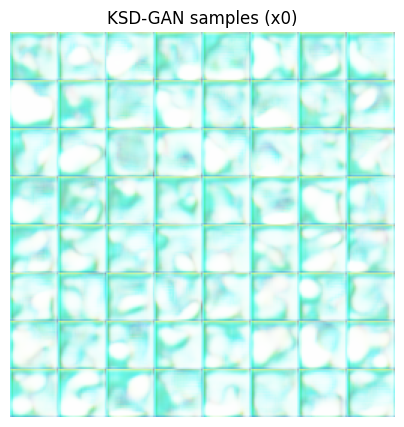

In [3]:
# ============================================================
# Rényi-Nyström KSD-GAN vs Standard GAN (CIFAR-10 32x32)
# Feature map: frozen ResNet18 features (ImageNet-pretrained)
# Gradient-dependent Stein terms are skipped in no-grad paths
# ============================================================

import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models
from torchvision.models.feature_extraction import create_feature_extractor
from diffusers import DDPMPipeline

# ----------------------------
# Repro / device
# ----------------------------
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ============================================================
# (1) Load pretrained DDPM (CIFAR-10)
# ============================================================
pipe = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
pipe.set_progress_bar_config(disable=True)
unet = pipe.unet.eval()
for p in unet.parameters():
    p.requires_grad_(False)

scheduler = pipe.scheduler
alphas_cumprod = scheduler.alphas_cumprod.to(device)
T = alphas_cumprod.numel()

def add_ddpm_noise(x0, t, eps=None):
    if eps is None:
        eps = torch.randn_like(x0)
    a_bar = alphas_cumprod[int(t)]
    mean_coeff = torch.sqrt(a_bar)
    sigma_t = torch.sqrt(1.0 - a_bar)
    x_t = mean_coeff * x0 + sigma_t * eps
    return x_t, sigma_t

def score_fn_xt(x_t, t, sigma_t=None, with_grad=False):
    t = int(t)
    if sigma_t is None:
        sigma_t = torch.sqrt(1.0 - alphas_cumprod[t])
    t_tensor = torch.full((x_t.shape[0],), t, device=x_t.device, dtype=torch.long)
    if with_grad:
        eps_pred = unet(x_t, t_tensor).sample
    else:
        with torch.no_grad():
            eps_pred = unet(x_t, t_tensor).sample
    return -(eps_pred / sigma_t)

# ============================================================
# (2) CIFAR loader in [-1,1]
# ============================================================
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda z: z * 2 - 1),
])
cifar = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
loader = torch.utils.data.DataLoader(
    cifar, batch_size=8, shuffle=True, num_workers=2, drop_last=True
)

# ============================================================
# (3) Feature map: frozen ResNet
# ============================================================
class FrozenResNetFeatureMap(nn.Module):
    def __init__(self, layer_name="layer3", resize_to_224=False):
        super().__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        backbone = models.resnet18(weights=weights)
        for p in backbone.parameters():
            p.requires_grad_(False)
        self.extractor = create_feature_extractor(
            backbone, return_nodes={layer_name: "feat"}
        )
        trans = weights.transforms()
        if hasattr(trans, "mean") and hasattr(trans, "std"):
            mean, std = trans.mean, trans.std
        elif hasattr(trans, "normalize"):
            mean, std = trans.normalize.mean, trans.normalize.std
        else:
            mean = (0.485, 0.456, 0.406)
            std = (0.229, 0.224, 0.225)
        self.register_buffer("mean", torch.tensor(mean, dtype=torch.float32).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor(std, dtype=torch.float32).view(1, 3, 1, 1))
        self.resize_to_224 = resize_to_224

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = (x + 1.0) / 2.0
        if self.resize_to_224:
            x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
        x = (x - self.mean) / self.std
        feats = self.extractor(x)["feat"]
        feats = F.adaptive_avg_pool2d(feats, 1)
        return feats.flatten(1)

@torch.no_grad()
def feat_stats_from_real(real_t, feat_map: nn.Module, eps=1e-6):
    Z = feat_map(real_t)
    mu = Z.mean(dim=0, keepdim=True)
    std = Z.std(dim=0, keepdim=True).clamp_min(eps)
    return mu.detach(), std.detach()

def apply_feat_norm(X_t, feat_map: nn.Module, mu, std):
    Z = feat_map(X_t)
    return (Z - mu) / std

@torch.no_grad()
def median_sigma2_from_real(real_t, feat_map: nn.Module, mu, std,
                            num_pairs=512, eps=1e-6, clamp_min=1e-3, clamp_max=1e3):
    Z = apply_feat_norm(real_t, feat_map, mu, std)
    B = Z.size(0)
    i = torch.randint(0, B, (num_pairs,), device=real_t.device)
    j = torch.randint(0, B, (num_pairs,), device=real_t.device)
    dist2 = ((Z[i] - Z[j])**2).sum(dim=1)
    med = torch.median(dist2)
    sigma2 = 0.5 * med + eps
    sigma2 = float(torch.clamp(sigma2, clamp_min, clamp_max).item())
    return sigma2

# ============================================================
# (4) MMD^2 in normalized feature space (unbiased)
# ============================================================
def mmd2_rbf_feat_norm(real_t, fake_t, feat_map, mu, std, sigma2: float, eps: float = 1e-12):
    Zr = apply_feat_norm(real_t, feat_map, mu, std)
    Zf = apply_feat_norm(fake_t, feat_map, mu, std)
    n, m = Zr.size(0), Zf.size(0)
    if n < 2 or m < 2:
        raise ValueError("Need at least 2 samples per batch for unbiased MMD^2")

    XX = torch.cdist(Zr, Zr, p=2.0)**2
    YY = torch.cdist(Zf, Zf, p=2.0)**2
    XY = torch.cdist(Zr, Zf, p=2.0)**2

    Kxx = torch.exp(-XX / (2.0 * sigma2))
    Kyy = torch.exp(-YY / (2.0 * sigma2))
    Kxy = torch.exp(-XY / (2.0 * sigma2))

    Kxx_sum = (Kxx.sum() - torch.diagonal(Kxx).sum()) / (n * (n - 1) + eps)
    Kyy_sum = (Kyy.sum() - torch.diagonal(Kyy).sum()) / (m * (m - 1) + eps)
    Kxy_sum = Kxy.mean()

    return torch.clamp(Kxx_sum + Kyy_sum - 2.0 * Kxy_sum, min=0.0)

# ============================================================
# (5) Nyström two-sample KSD in normalized feature space
# ============================================================
def vjp_feat_norm(feat_map, x_single, v, mu, std, create_graph: bool):
    x = x_single.unsqueeze(0).requires_grad_(True)
    z = feat_map(x)
    z_norm = (z - mu) / std
    scalar = (z_norm * v).sum()
    (gx,) = torch.autograd.grad(scalar, x, retain_graph=True, create_graph=create_graph)
    return gx.squeeze(0).flatten()

class RenyiNystroemKSD(nn.Module):
    def __init__(self, feat_map: nn.Module, ridge=1e-3, m_fn=lambda n: min(16, n)):
        super().__init__()
        self.feat_map = feat_map
        self.ridge = float(ridge)
        self.m_fn = m_fn

    def _stein_kernel(self, X, Y, t, sigma_t, sigma2, mu, std,
                      with_grad_score=False, grad_terms=True):
        """
        grad_terms=False: skip VJPs/Hessian to avoid autograd in no-grad sections.
        """
        n, m = X.shape[0], Y.shape[0]
        sX = score_fn_xt(X, t, sigma_t, with_grad=with_grad_score).view(n, -1)
        sY = score_fn_xt(Y, t, sigma_t, with_grad=with_grad_score).view(m, -1)

        Zx = (self.feat_map(X) - mu) / std
        Zy = (self.feat_map(Y) - mu) / std
        diffz = Zx[:, None, :] - Zy[None, :, :]
        dist2 = (diffz * diffz).sum(dim=2)
        K = torch.exp(-dist2 / (2.0 * sigma2))
        gram = sX @ sY.T

        if not grad_terms:
            return K * gram  # no VJPs/Hessian

        with torch.enable_grad():
            gradZ = -(diffz / sigma2) * K[:, :, None]
            gradX_list = []
            for i in range(n):
                gx_rows = []
                xi = X[i]
                for j in range(m):
                    v = gradZ[i, j]
                    gx = vjp_feat_norm(self.feat_map, xi, v, mu, std, create_graph=with_grad_score)
                    gx_rows.append(gx)
                gradX_list.append(torch.stack(gx_rows, dim=0))
            gradX = torch.stack(gradX_list, dim=0)

            gradY_list = []
            for j in range(m):
                gy_rows = []
                yj = Y[j]
                for i in range(n):
                    v = -gradZ[i, j]
                    gy = vjp_feat_norm(self.feat_map, yj, v, mu, std, create_graph=with_grad_score)
                    gy_rows.append(gy)
                gradY_list.append(torch.stack(gy_rows, dim=0))
            gradY = torch.stack(gradY_list, dim=0).transpose(0, 1)

            B = (gradX * sY[None, :, :]).sum(dim=2)
            C = (gradY * sX[:, None, :]).sum(dim=2)
            gradXY = torch.zeros_like(K)  # omit mixed Hessian
            return K * gram + B + C + gradXY

    @torch.no_grad()
    def stabilize_Hmm(self, H_mm):
        H_mm = 0.5 * (H_mm + H_mm.T)
        I = torch.eye(H_mm.shape[0], device=H_mm.device, dtype=H_mm.dtype)
        min_eig = torch.linalg.eigvalsh(H_mm).min()
        shift = (-min_eig).clamp(min=0.0)
        return H_mm + (shift + self.ridge) * I

    def two_sample_with_landmarks(self, real_t, fake_t, t, sigma_t, Z_m, sigma2, mu, std, with_grad_fake_score=True):
        real_t = real_t.detach()
        Z_m = Z_m.detach()

        n_r = real_t.size(0)
        n_f = fake_t.size(0)

        H_mm = self._stein_kernel(Z_m, Z_m, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std,
                                  with_grad_score=False, grad_terms=False)
        H_mm_reg = self.stabilize_Hmm(H_mm)

        H_mr = self._stein_kernel(Z_m, real_t, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std,
                                  with_grad_score=False, grad_terms=False)
        H_mf = self._stein_kernel(Z_m, fake_t, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std,
                                  with_grad_score=with_grad_fake_score, grad_terms=True)

        beta_r = H_mr @ (torch.ones(n_r, 1, device=real_t.device, dtype=H_mr.dtype) / n_r)
        beta_f = H_mf @ (torch.ones(n_f, 1, device=fake_t.device, dtype=H_mf.dtype) / n_f)

        delta = beta_f - beta_r
        x = torch.linalg.solve(H_mm_reg, delta)
        return (delta.T @ x).squeeze()

    @torch.no_grad()
    def one_sample_with_landmarks(self, X_t, t, sigma_t, Z_m, sigma2, mu, std):
        n = X_t.size(0)
        H_mn = self._stein_kernel(Z_m, X_t, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std,
                                  with_grad_score=False, grad_terms=False)
        H_mm = self._stein_kernel(Z_m, Z_m, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std,
                                  with_grad_score=False, grad_terms=False)
        H_mm_reg = self.stabilize_Hmm(H_mm)
        beta = H_mn @ (torch.ones(n, 1, device=X_t.device, dtype=H_mn.dtype) / n)
        x = torch.linalg.solve(H_mm_reg, beta)
        return (beta.T @ x).squeeze()

# ============================================================
# (6) Landmark selection
# ============================================================
@torch.no_grad()
def select_renyi_landmarks_stein(ksd_obj, X_t, t, sigma_t, sigma2, mu, std, m,
                                 use_abs=True, jitter=0.0):
    n = X_t.size(0)
    m = min(int(m), n)

    H = ksd_obj._stein_kernel(X_t, X_t, t=int(t), sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std,
                              with_grad_score=False, grad_terms=False)
    H = 0.5 * (H + H.T)
    if jitter > 0:
        H = H + jitter * torch.eye(n, device=X_t.device, dtype=H.dtype)

    A = H.abs() if use_abs else H
    diag = torch.diagonal(A)
    row_sums = A.sum(dim=1)
    first = torch.argmin(row_sums).item()

    selected = [first]
    cross_sums = A[:, first].clone()
    while len(selected) < m:
        scores = 2 * cross_sums + diag
        scores[selected] = float("inf")
        nxt = torch.argmin(scores).item()
        selected.append(nxt)
        cross_sums += A[:, nxt]

    return torch.tensor(selected, device=X_t.device, dtype=torch.long)

# ============================================================
# (7) Generator and (8) Discriminator (baseline GAN)
# ============================================================
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        return x

class GenX0(nn.Module):
    def __init__(self, z_dim=128, ch=256):
        super().__init__()
        self.fc = nn.Linear(z_dim, ch*4*4)
        self.up1 = UpBlock(ch, ch//2)
        self.up2 = UpBlock(ch//2, ch//4)
        self.up3 = UpBlock(ch//4, ch//8)
        self.out = nn.Conv2d(ch//8, 3, 3, padding=1)

    def forward(self, z):
        if z.dim() == 4:
            z = z[:, :, 0, 0]
        x = self.fc(z).view(z.size(0), -1, 4, 4)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = torch.tanh(self.out(x))
        return x

class DCGANDis(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)

# ============================================================
# (9) Visualization helpers
# ============================================================
@torch.no_grad()
def show_samples(x, title="samples", n=64):
    x = x[:n].detach().cpu()
    x = (x + 1) / 2.0
    s = int(np.sqrt(n))
    x = x[:s*s]
    grid = x.view(s, s, 3, 32, 32).permute(0, 3, 1, 4, 2).reshape(s*32, s*32, 3).numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

def sample_t_mixture(step, steps_total, T,
                     t_hi=(0.70, 0.95),
                     t_mid=(0.20, 0.70),
                     t_lo=(0.02, 0.15),
                     p_lo_final=0.60,
                     p_hi_initial=0.60,
                     K_T=2):
    frac = step / max(1, steps_total - 1)
    p_lo = (p_lo_final) * frac
    p_hi = (p_hi_initial) * (1 - frac)
    p_mid = max(0.0, 1.0 - p_lo - p_hi)

    def draw_from(rng):
        a = int(rng[0] * (T-1))
        b = int(rng[1] * (T-1))
        return int(torch.randint(a, b+1, (1,), device=device).item())

    ts = []
    for _ in range(K_T):
        u = np.random.rand()
        if u < p_lo:
            ts.append(draw_from(t_lo))
        elif u < p_lo + p_mid:
            ts.append(draw_from(t_mid))
        else:
            ts.append(draw_from(t_hi))
    return ts

def t_weight(sigma_t, power=2.0, eps=1e-3):
    return 1.0 / (float(sigma_t.item())**power + eps)

# ============================================================
# (10) Train Rényi-KSD GAN (ResNet features)
# ============================================================
feat_map = FrozenResNetFeatureMap(layer_name="layer2", resize_to_224=False).to(device)
ksd = RenyiNystroemKSD(feat_map=feat_map, ridge=1e-3).to(device)

G_ksd = GenX0(z_dim=128, ch=256).to(device)
opt_ksd = torch.optim.Adam(G_ksd.parameters(), lr=2e-4, betas=(0.5, 0.999))

steps = 1000  # adjust as needed
batch_size = 32
z_dim = 128
log_every = 25

K_T = 1
LAMBDA_MMD = 0.50
USE_T_WEIGHT = False
CLIP_GRAD = 5.0

it = iter(loader)

for step in range(1, steps + 1):
    try:
        real0, _ = next(it)
    except StopIteration:
        it = iter(loader)
        real0, _ = next(it)

    real0 = real0.to(device)
    z = torch.randn(batch_size, z_dim, device=device)
    fake0 = G_ksd(z)

    t_list = sample_t_mixture(step, steps, T, K_T=K_T)

    loss_terms = []
    for t in t_list:
        fake_t, sigma_t = add_ddpm_noise(fake0, t)
        real_t, _       = add_ddpm_noise(real0, t)

        with torch.no_grad():
            mu, std = feat_stats_from_real(real_t, feat_map)
            sigma2 = median_sigma2_from_real(real_t, feat_map, mu, std, num_pairs=256)

            m = min(ksd.m_fn(real_t.size(0)), real_t.size(0))
            idx = select_renyi_landmarks_stein(
                ksd_obj=ksd,
                X_t=real_t.detach(),
                t=t,
                sigma_t=sigma_t,
                sigma2=sigma2,
                mu=mu, std=std,
                m=m,
                use_abs=True,
                jitter=0.0
            )
            Z_m = real_t[idx].detach()

        ksd_val = ksd.two_sample_with_landmarks(
            real_t=real_t,
            fake_t=fake_t,
            t=t,
            sigma_t=sigma_t,
            Z_m=Z_m,
            sigma2=sigma2,
            mu=mu, std=std,
            with_grad_fake_score=True
        )

        mmd_val = mmd2_rbf_feat_norm(real_t, fake_t, feat_map, mu, std, sigma2=sigma2)
        term = ksd_val + LAMBDA_MMD * mmd_val
        if USE_T_WEIGHT:
            term = term * t_weight(sigma_t, power=2.0, eps=1e-3)
        loss_terms.append(term)

    loss = torch.stack(loss_terms).mean()

    if not torch.isfinite(loss):
        print(f"[step {step}] non-finite loss -> skip")
        opt_ksd.zero_grad(set_to_none=True)
        continue

    opt_ksd.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(G_ksd.parameters(), CLIP_GRAD)
    opt_ksd.step()

    if step % log_every == 0:
        print(f"[KSD-GAN] step {step:4d}/{steps} | loss={loss.item():.4f} | t_list={t_list}")

with torch.no_grad():
    z = torch.randn(64, z_dim, device=device)
    x0 = G_ksd(z)
show_samples(x0, title="KSD-GAN samples (x0)")


[GAN] step  100/1000 | lossD=1.406 | lossG=1.464
[GAN] step  200/1000 | lossD=1.346 | lossG=1.132
[GAN] step  300/1000 | lossD=1.271 | lossG=1.225
[GAN] step  400/1000 | lossD=1.317 | lossG=1.162
[GAN] step  500/1000 | lossD=1.130 | lossG=1.236
[GAN] step  600/1000 | lossD=1.082 | lossG=1.180
[GAN] step  700/1000 | lossD=1.543 | lossG=1.033
[GAN] step  800/1000 | lossD=1.712 | lossG=0.859
[GAN] step  900/1000 | lossD=1.259 | lossG=1.049
[GAN] step 1000/1000 | lossD=1.611 | lossG=0.878


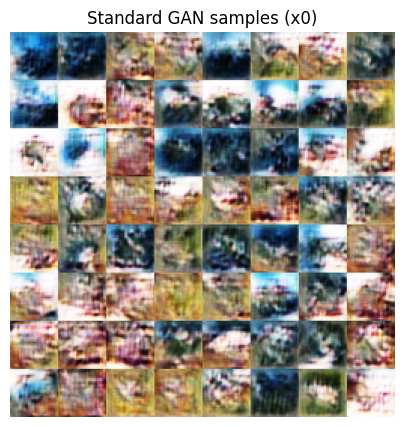

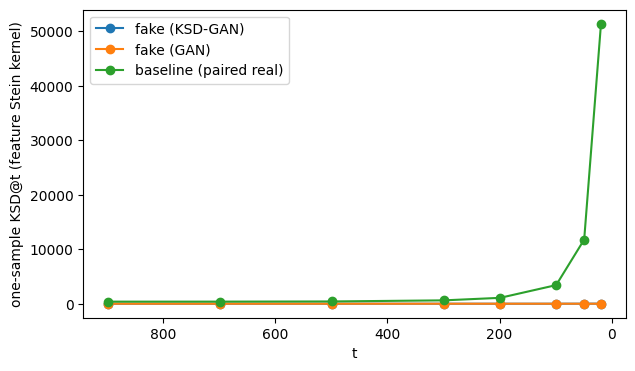

In [4]:
# ============================================================
# (11) Train standard GAN baseline (x0)
# ============================================================
def train_standard_gan(steps=300, batch_size=32, z_dim=128, lr=2e-4, d_steps=1, log_every=100):
    G = GenX0(z_dim=z_dim, ch=256).to(device)
    Dnet = DCGANDis().to(device)
    optG = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optD = torch.optim.Adam(Dnet.parameters(), lr=lr, betas=(0.5, 0.999))
    bce = nn.BCEWithLogitsLoss()

    it = iter(loader)
    for step in range(1, steps + 1):
        try:
            real, _ = next(it)
        except StopIteration:
            it = iter(loader)
            real, _ = next(it)
        real = real.to(device)

        for _ in range(d_steps):
            z = torch.randn(batch_size, z_dim, device=device)
            fake = G(z).detach()
            logits_real = Dnet(real)
            logits_fake = Dnet(fake)
            y_real = torch.ones_like(logits_real) * 0.9
            y_fake = torch.zeros_like(logits_fake)
            lossD = bce(logits_real, y_real) + bce(logits_fake, y_fake)
            optD.zero_grad(set_to_none=True)
            lossD.backward()
            optD.step()

        z = torch.randn(batch_size, z_dim, device=device)
        fake = G(z)
        logits_fake = Dnet(fake)
        y_gen = torch.ones_like(logits_fake)
        lossG = bce(logits_fake, y_gen)
        optG.zero_grad(set_to_none=True)
        lossG.backward()
        optG.step()

        if step % log_every == 0:
            print(f"[GAN] step {step:4d}/{steps} | lossD={lossD.item():.3f} | lossG={lossG.item():.3f}")

    return G.eval(), Dnet.eval()

G_gan, D_gan = train_standard_gan(steps=1000, batch_size=32, z_dim=128, log_every=100)
with torch.no_grad():
    z = torch.randn(64, z_dim, device=device)
    x0 = G_gan(z)
show_samples(x0, title="Standard GAN samples (x0)")

# ============================================================
# (12) Eval: paired one-sample KSD@t for real vs fake
# ============================================================
@torch.no_grad()
def eval_ksd_over_t_paired(G, t_list, ridge_override=1e-2, batch_size=32, z_dim=128):
    old_ridge = ksd.ridge
    ksd.ridge = float(ridge_override)

    it = iter(loader)
    real_vals, fake_vals = [], []

    for t in t_list:
        real0, _ = next(it)
        real0 = real0.to(device)

        z = torch.randn(batch_size, z_dim, device=device)
        fake0 = G(z)

        real_t, sigma_t = add_ddpm_noise(real0, t)
        fake_t, _       = add_ddpm_noise(fake0, t)

        mu, std = feat_stats_from_real(real_t, feat_map)
        sigma2  = median_sigma2_from_real(real_t, feat_map, mu, std)

        m = min(ksd.m_fn(real_t.size(0)), real_t.size(0))
        idx = select_renyi_landmarks_stein(ksd, real_t, t=t, sigma_t=sigma_t, sigma2=sigma2, mu=mu, std=std, m=m)
        Z_m = real_t[idx]

        v_real = ksd.one_sample_with_landmarks(real_t, t=t, sigma_t=sigma_t, Z_m=Z_m, sigma2=sigma2, mu=mu, std=std)
        v_fake = ksd.one_sample_with_landmarks(fake_t, t=t, sigma_t=sigma_t, Z_m=Z_m, sigma2=sigma2, mu=mu, std=std)

        real_vals.append(float(v_real.item()))
        fake_vals.append(float(v_fake.item()))

    ksd.ridge = old_ridge
    return np.array(real_vals), np.array(fake_vals)

t_list_eval = [int(x*(T-1)) for x in [0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.02]]

real_ksd, fake_ksd = eval_ksd_over_t_paired(G_ksd, t_list_eval, ridge_override=1e-2)
real_gan, fake_gan = eval_ksd_over_t_paired(G_gan, t_list_eval, ridge_override=1e-2)

plt.figure(figsize=(7,4))
plt.plot(t_list_eval, fake_ksd, marker="o", label="fake (KSD-GAN)")
plt.plot(t_list_eval, fake_gan, marker="o", label="fake (GAN)")
plt.plot(t_list_eval, real_ksd, marker="o", label="baseline (paired real)")
plt.gca().invert_xaxis()
plt.xlabel("t")
plt.ylabel("one-sample KSD@t (feature Stein kernel)")
plt.legend()
plt.show()
